In [1]:
import src
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from pybedtools.bedtool import BedTool
from pybedtools import cleanup
cleanup()

figure_path = src.figures_path / "gene_families_and_boundaries"
os.makedirs(figure_path, exist_ok=True)

In [2]:
min_number_of_genes = 4
min_length = 100000

subclusters = pd.read_csv(src.interim_data_path / "gene_families_subcluster_regions.tsv", sep="\t")
subclusters = subclusters[src.coords + [c for c in subclusters.columns if c not in src.coords]]
subclusters = subclusters[subclusters.n_genes >= min_number_of_genes]
subclusters = subclusters[(subclusters.end - subclusters.start) >= min_length]
subclusters.head()

,chr,start,end,length,genes,ensembl_gene_id,n_genes,family_id,family_name,sub_cluster,cluster_uid
131,chr10,90346510,90580303,233793,"LIPJ,LIPF,LIPK,LIPN,LIPM","ENSG00000204022,ENSG00000182333,ENSG0000020402...",5,46,AB hydrolase superfamily. Lipase family,0,46_0
150,chr17,66863433,67323385,459952,"ABCA8,ABCA9,ABCA6,ABCA10,ABCA5","ENSG00000141338,ENSG00000154258,ENSG0000015426...",5,49,ABC transporter superfamily. ABCA family,2,49_2
530,chr20,31595406,31699557,104151,"BPIFB2,BPIFB6,BPIFB3,BPIFB4","ENSG00000078898,ENSG00000167104,ENSG0000018619...",4,249,BPI/LBP/Plunc superfamily. BPI/LBP family,1,249_1
710,chr17,72462555,72588422,125867,"CD300A,CD300LB,CD300C,CD300LD","ENSG00000167851,ENSG00000178789,ENSG0000016785...",4,332,CD300 family,1,332_1
1805,chr1,158368312,158533394,165082,"OR10T2,OR10K2,OR10K1,OR10R2,OR6Y1,OR6P1","ENSG00000186306,ENSG00000180708,ENSG0000017328...",6,919,G-protein coupled receptor 1 family,16,919_16


In [13]:
subclusters.shape

(137, 11)

In [6]:
window = 25000
cons_bounds = pd.read_csv(src.interim_data_path / "consensus_boundaries" / "consensus_boundaries_w{}.tsv".format(window), sep="\t")
cons_bounds = pd.concat((cons_bounds, pd.get_dummies(cons_bounds.n_cell_types)), axis=1)
cons_bounds.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,...,nCD8,length,covered_genome,1,2,3,4,5,6,7
0,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,...,0,1,3.223947e-10,1,0,0,0,0,0,0
1,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,...,0,1,3.223947e-10,1,0,0,0,0,0,0
2,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,...,0,5001,1.612296e-06,0,0,1,0,0,0,0
3,chr1,2112500,2112500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,...,0,1,3.223947e-10,0,1,0,0,0,0,0
4,chr1,2342500,2350000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nCD8,Ery,nB,Mac0",4,5,1,0,1,...,1,7501,2.418282e-06,0,0,0,1,0,0,0


In [7]:
subclusters_bounds = BedTool.from_dataframe(subclusters.sort_values(src.coords))\
                            .intersect(BedTool.from_dataframe(cons_bounds.sort_values(src.coords)), wa=True, wb=True)\
                            .to_dataframe(names = subclusters.columns.tolist() + cons_bounds.columns.tolist())
subclusters_bounds = subclusters_bounds.groupby(['family_id', 'sub_cluster', 'n_genes']).n_cell_types.max().reset_index()
subclusters_bounds = subclusters_bounds[['family_id', 'sub_cluster', 'n_genes', 'n_cell_types']]
subclusters_bounds = subclusters_bounds.merge(subclusters[['family_id', 'sub_cluster', 'n_genes']], how='right').fillna(0).astype(int)
subclusters_bounds.head()

/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,family_id,sub_cluster,n_genes,n_cell_types
0,46,0,5,6
1,49,2,5,3
2,332,1,4,4
3,919,16,6,4
4,919,27,10,5


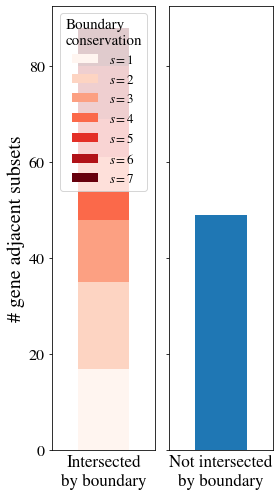

In [8]:
fig, axes = plt.subplots(1,2,sharey=True, figsize=(4,7))
x = subclusters_bounds.assign(has_boundary=lambda y: y.n_cell_types\
                                                  .map(lambda x: 'Intersected\nby boundary' if x >= 1 else "Not intersected\nby boundary"))\
                  .groupby(['has_boundary', 'n_cell_types']).size().unstack().fillna(0).astype(int)
ax0_plot = x.loc[['Intersected\nby boundary'], range(1, 8)].rename(columns=lambda x: "$s = {}$".format(x)).plot.bar(stacked=True, ax=axes[0], cmap='Reds')
axes[0].set_xticks([])
axes[0].set_xlabel("Intersected\nby boundary")
axes[0].legend(title='Boundary\nconservation', title_fontsize=15, loc='upper center', bbox_to_anchor =(0.5,1.0))
axes[0].set_ylabel("# gene adjacent subsets", fontsize=20)
# axes[0].set_ylim(0, 800)
axes[1].bar(x=0, height=x.loc['Not intersected\nby boundary', 0], width=1)
axes[1].set_xlim(-1,1)
axes[1].set_xticks([])
axes[1].set_xlabel("Not intersected\nby boundary")
plt.xticks(rotation=0)
# fig.savefig(figure_path / "subclusters_on_boundaries.pdf", bbox_inches='tight', transparent=True)
plt.show()

In [63]:
subclusters_bounds = BedTool.from_dataframe(subclusters.sort_values(src.coords))\
                            .intersect(BedTool.from_dataframe(cons_bounds.sort_values(src.coords)), wa=True, wb=True)\
                            .to_dataframe(names = subclusters.columns.tolist() + cons_bounds.columns.tolist())
subclusters_bounds = subclusters_bounds.groupby(['family_id', 'sub_cluster', 'n_genes']).agg({k:"sum" for k in range(1,8)})
subclusters_bounds['n_intersecting_boundaries'] = subclusters_bounds.sum(1)
subclusters_bounds = subclusters_bounds.reset_index()
subclusters_bounds = subclusters_bounds.merge(subclusters[['family_id', 'sub_cluster', 'n_genes']], how='right').fillna(0).astype(int)
subclusters_bounds.loc[subclusters_bounds.n_intersecting_boundaries == 0, 0] = 1
subclusters_bounds = subclusters_bounds.fillna(0).astype(int)
subclusters_bounds.head()

/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,family_id,sub_cluster,n_genes,1,2,3,4,5,6,7,n_intersecting_boundaries,0
0,16,52,8,0,1,0,0,0,0,0,1,0
1,16,56,20,2,0,0,0,0,0,0,2,0
2,19,7,8,0,1,0,0,0,0,0,1,0
3,19,11,20,2,0,0,0,0,0,0,2,0
4,20,1,8,0,1,0,0,0,0,0,1,0


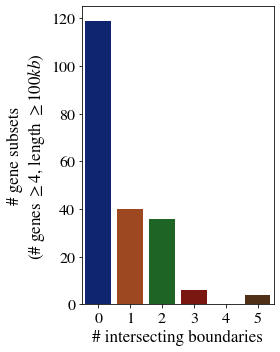

In [79]:
plt.figure(figsize=(4, 5))
sns.countplot(subclusters_bounds.n_intersecting_boundaries, palette='dark', order=range(0,6))
plt.xlabel("# intersecting boundaries")
plt.ylabel("# gene subsets\n(# genes $\geq 4$, length $\geq 100kb$)")
plt.show()